In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import emcee
import corner

In [2]:
%matplotlib notebook

In [3]:
marshal_df = pd.read_csv('../data/phot/Marshal.lc')
marshal_df.head(5)

,date,jdobs,filter,absmag,magpsf,sigmamagpsf,limmag,instrument,programid,reducedby,refsys,issub,isdiffpos
0,2019 Dec 06,2.458824e+06,g,99.0,99.0,99.0,18.14,P48+ZTF,1,None,None,True,True
1,2019 Dec 10,2.458828e+06,r,99.0,99.0,99.0,19.26,P48+ZTF,1,None,None,True,True
2,2019 Dec 11,2.458829e+06,r,99.0,99.0,99.0,19.70,P48+ZTF,1,None,None,True,True
3,2019 Dec 11,2.458829e+06,g,99.0,99.0,99.0,20.00,P48+ZTF,1,None,None,True,True
4,2019 Dec 13,2.458831e+06,r,99.0,99.0,99.0,19.80,P48+ZTF,1,None,None,True,True


In [4]:
bobs = np.where(marshal_df['filter'] == 'B')
Bmjd = marshal_df.iloc[bobs].jdobs.values - 2400000.5
Bmag = marshal_df.iloc[bobs].magpsf.values
Bmag_unc = marshal_df.iloc[bobs].sigmamagpsf.values

## Fit 3rd order polynomial

In [5]:
def lnlike(theta, t, m, m_unc):
    
    p0, p1, p2, p3 = theta
    
    model = p0 + p1*t + p2*t**2 + p3*t**3
    
    lnl = -0.5*np.sum((m - model)**2/m_unc**2)
    
    return lnl

def neg_lnlike(theta, t, m, m_unc):
    return -1*lnlike(theta, t, m, m_unc)

In [6]:
from scipy.optimize import minimize

In [54]:
near_peak = np.where((Bmjd > 58853) & (Bmjd < 58871))

toffset = 58862
ml_res = minimize(neg_lnlike, (15, -0.05,0.01, 0.001), method='Powell', # Powell method does not need derivatives
                      args=(Bmjd[near_peak]-toffset, Bmag[near_peak], Bmag_unc[near_peak]))

In [55]:
ml_res

   direc: array([[-1.03444736e-01,  3.64191287e-02,  1.83000367e-03,
        -5.90812876e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 4.28178221e-02,  1.89005450e-02, -7.91953556e-04,
        -3.17954905e-04]])
     fun: 0.10133414436704243
 message: 'Optimization terminated successfully.'
    nfev: 260
     nit: 6
  status: 0
 success: True
       x: array([ 1.49908214e+01, -1.06401761e-02,  1.12223313e-02, -3.97527587e-04])

<IPython.core.display.Javascript object>


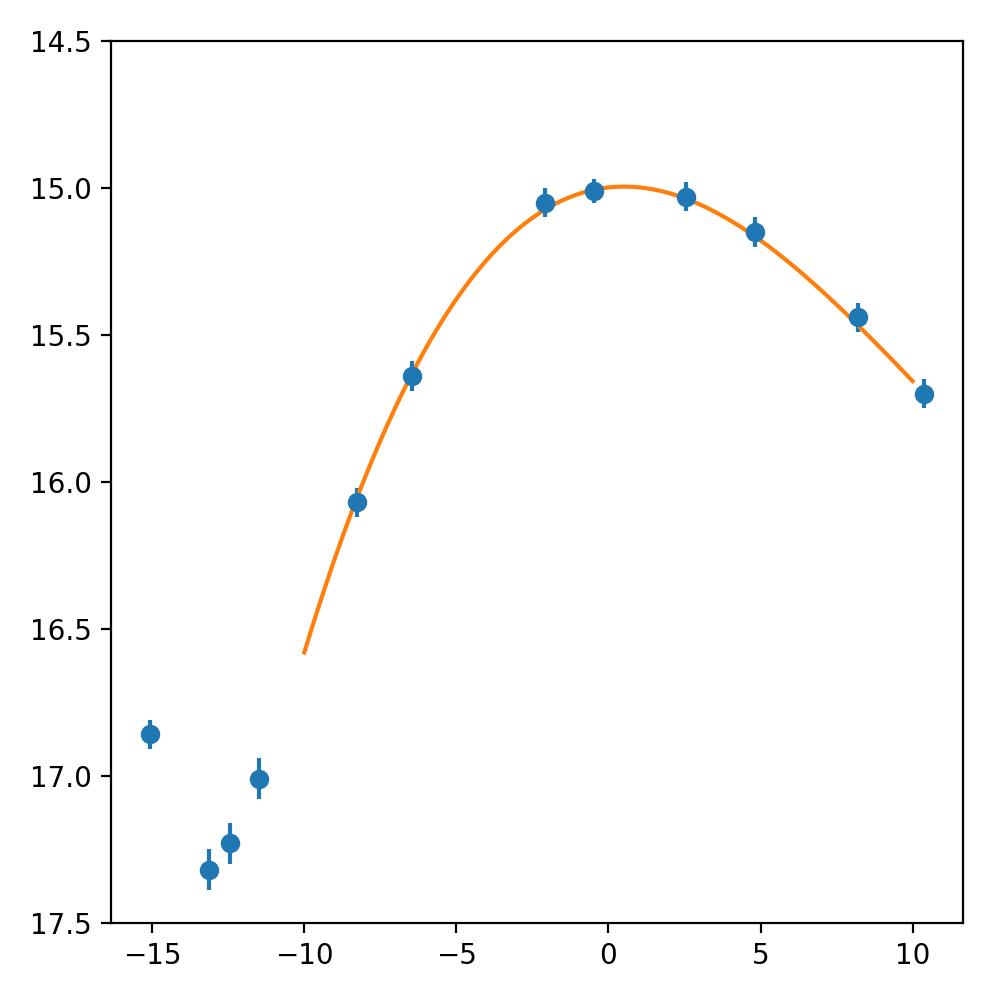

In [63]:
plt.figure(figsize=(5,5))
plt.errorbar(Bmjd-toffset, Bmag, Bmag_unc, fmt='o')
plt.ylim(17.5,14.5)

theta = samples[0]
t_grid = np.linspace(-10, 10,1000)

plt.plot(t_grid, theta[0] + theta[1]*t_grid + theta[2]*t_grid**2 + theta[3]*t_grid**3)
plt.tight_layout()

In [57]:
ml_guess = ml_res.x
ndim = len(ml_guess)
nfac = [10**(-2.5)]*ndim

nwalkers = 25

#initial position of walkers
rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
pos = ml_guess*rand_pos


In [58]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=(Bmjd[near_peak]-toffset, 
                                      Bmag[near_peak], 
                                      Bmag_unc[near_peak]))


max_samples = 100000

old_tau = np.inf
for sample in sampler.sample(pos, 
                             iterations=max_samples, 
                             progress=True):
    if sampler.iteration % int(2e3):
        continue
    

    tau = sampler.get_autocorr_time(tol=0)

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

 28%|██▊       | 28000/100000 [00:24<01:04, 1121.93it/s]


In [59]:
tau

array([49.05506858, 49.07862997, 49.72932624, 48.68180751])

<IPython.core.display.Javascript object>


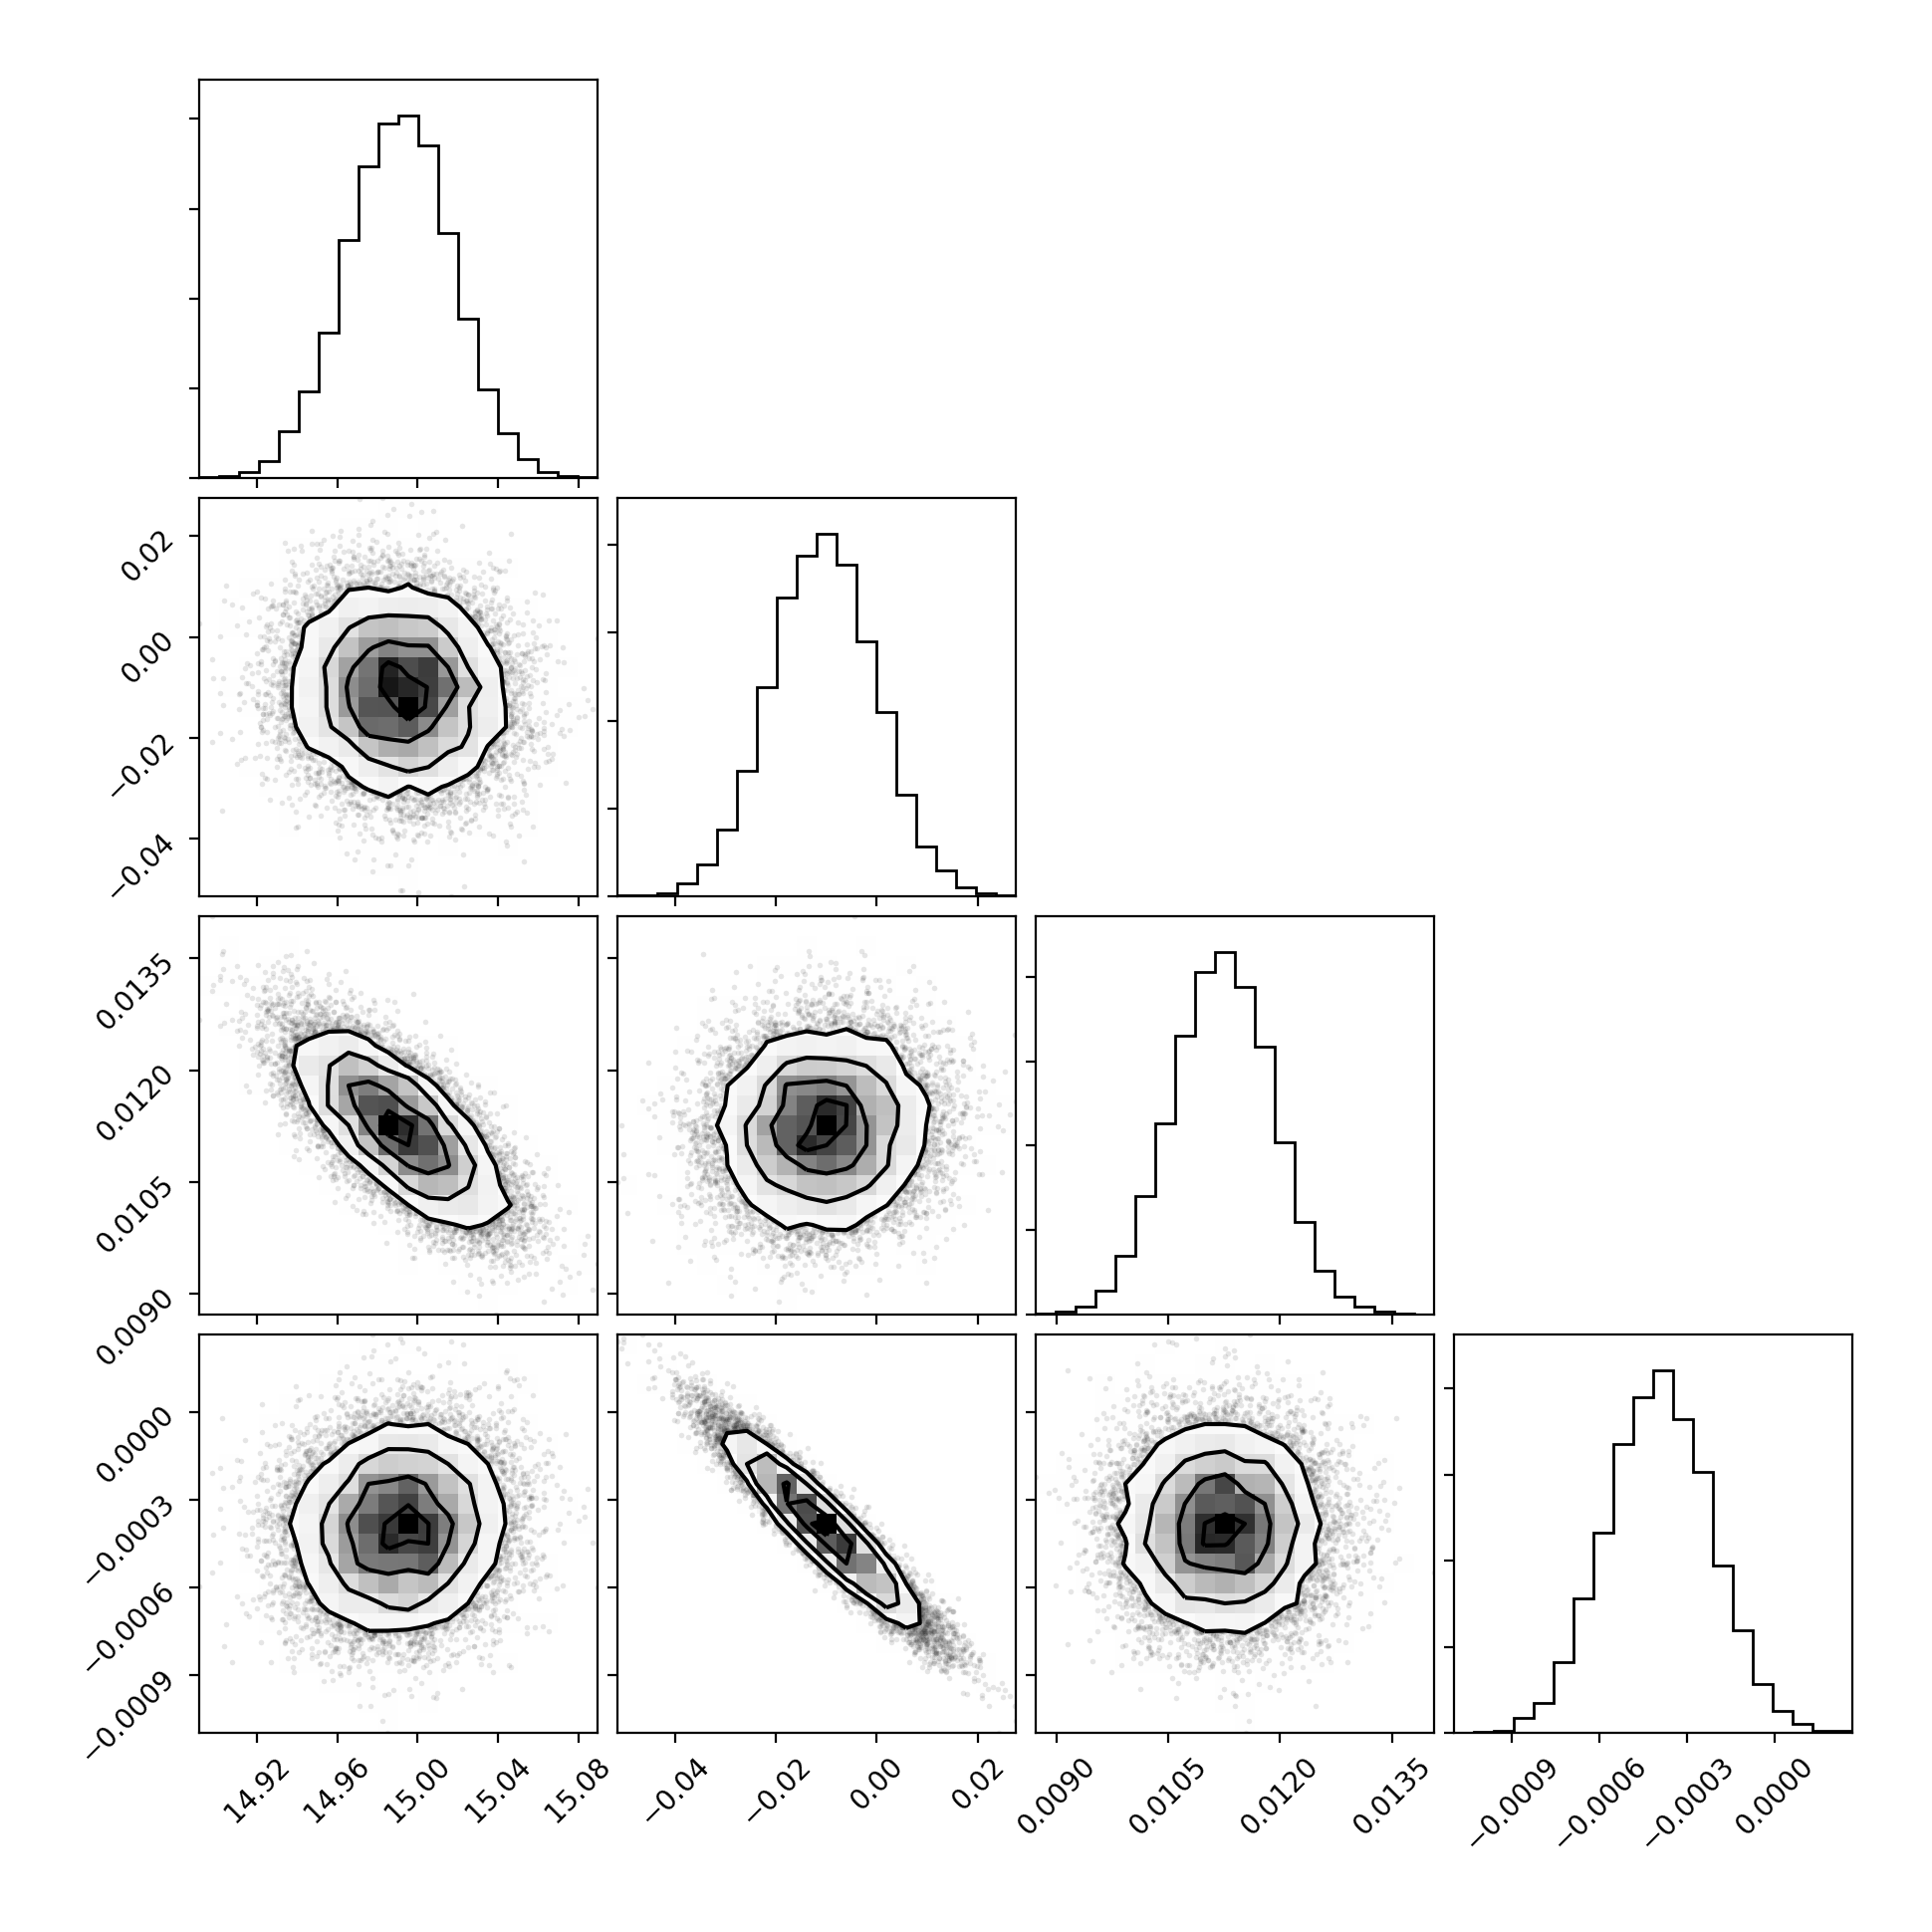

In [60]:
samples = sampler.get_chain(flat=True,
                            discard=10*np.ceil(np.max(tau)).astype(int),
                            thin=np.ceil(np.max(tau)).astype(int))
fig = corner.corner(samples)

<IPython.core.display.Javascript object>


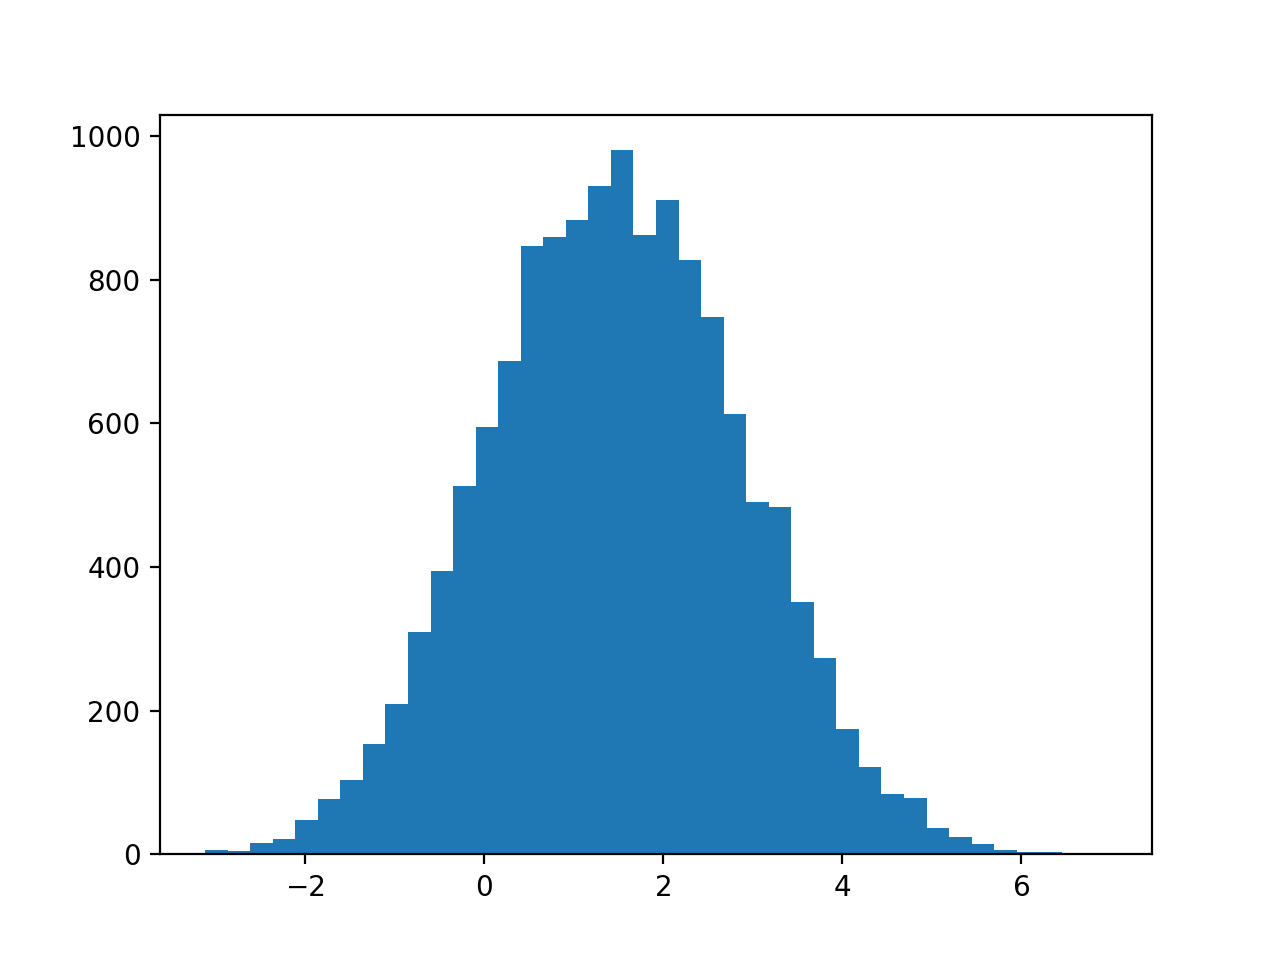

68% CR on t_peak is: [58862.03921468 58863.46613745 58864.91061901]


In [64]:
# derivative gives quadratic
# (-b +/- sqrt(b**2 - 4*a*c))/2a


t_peak = (-2*samples[:,2] + np.sqrt(4*samples[:,2]**2 - 4*samples[:,1]*3*samples[:,3]))/(2*samples[:,3])
plt.figure()
plt.hist(t_peak, bins=40)

print('68% CR on t_peak is: {}'.format(np.percentile(t_peak, (15.865,50,84.135)) + toffset))

[62.61828557 35.40636355 47.05468745 ... 81.78484364 54.53714166
 62.21997318]


<IPython.core.display.Javascript object>


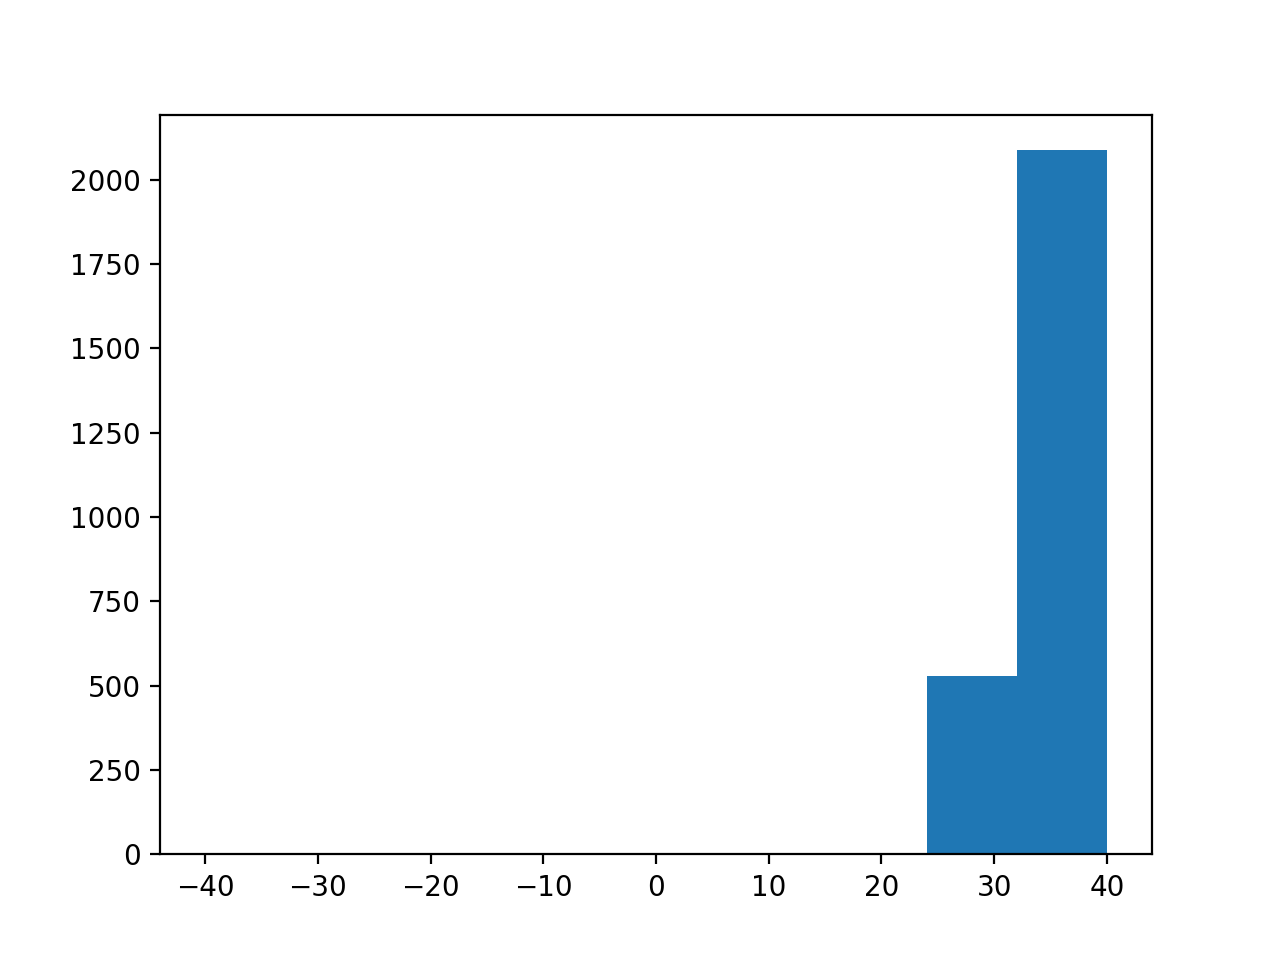

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    3.,  529.,
        2087.]),
 array([-40., -32., -24., -16.,  -8.,   0.,   8.,  16.,  24.,  32.,  40.]),
 <a list of 10 Patch objects>)

In [62]:
t_peak = (-2*samples[:,2] - np.sqrt(4*samples[:,2]**2 - 4*samples[:,1]*3*samples[:,3]))/(2*samples[:,3])
print(t_peak)
plt.figure()
plt.hist(t_peak, range=(-40,40))

In [32]:
samples[0]

array([ 1.49646876e+01, -9.61130820e-03,  1.16613934e-02, -2.17990471e-04])

### Fit a quadratic function

In [66]:
def lnlike(theta, t, m, m_unc):
    
    p0, p1, p2 = theta
    
    model = p0 + p1*t + p2*t**2
    
    lnl = -0.5*np.sum((m - model)**2/m_unc**2)
    
    return lnl

def neg_lnlike(theta, t, m, m_unc):
    return -1*lnlike(theta, t, m, m_unc)

[ 1.50024062e+01 -2.77053971e-02  1.03367505e-02]


<IPython.core.display.Javascript object>


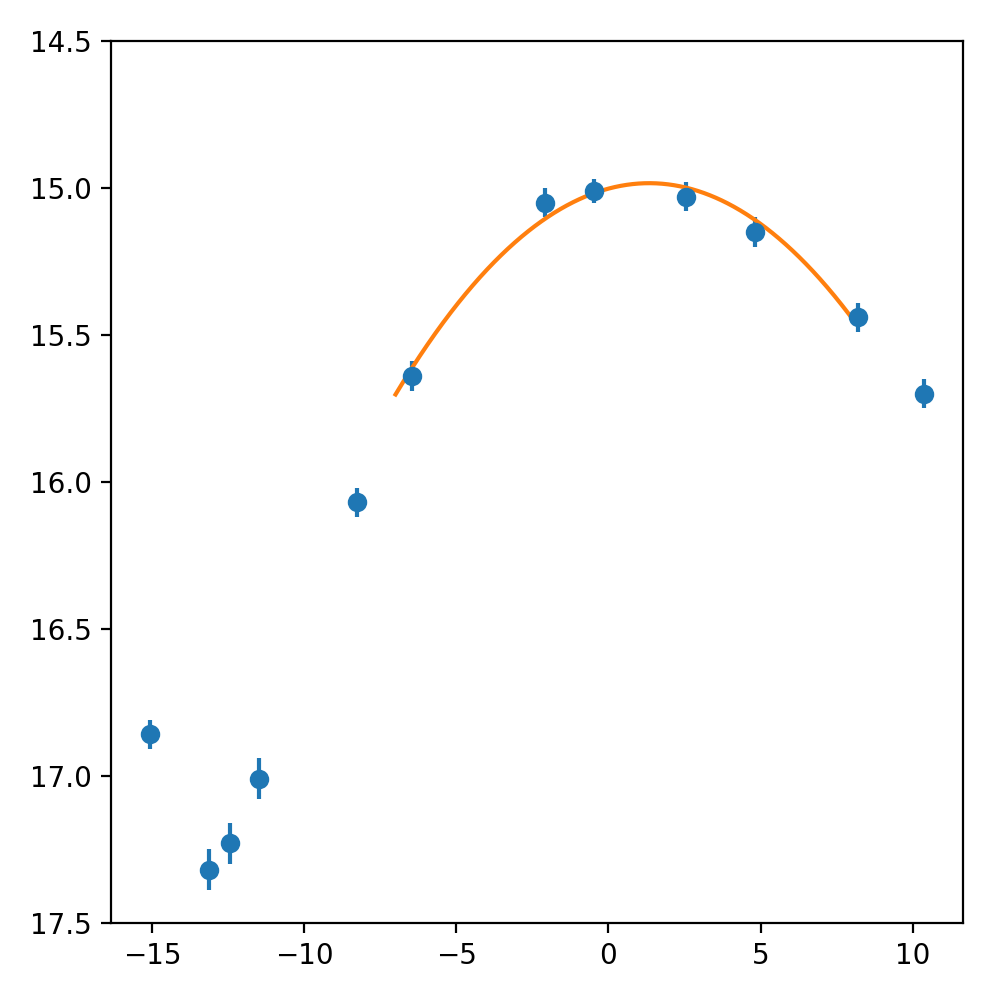

In [71]:
near_peak = np.where((Bmjd > 58855) & (Bmjd < 58871))

ml_res = minimize(neg_lnlike, (15, -0.05,0.01), method='Powell', # Powell method does not need derivatives
                      args=(Bmjd[near_peak]-toffset, Bmag[near_peak], Bmag_unc[near_peak]))
print(ml_res.x)

plt.figure(figsize=(5,5))
plt.errorbar(Bmjd-toffset, Bmag, Bmag_unc, fmt='o')
plt.ylim(17.5,14.5)

theta = ml_res.x
t_grid = np.linspace(-7, 8,1000)

plt.plot(t_grid, theta[0] + theta[1]*t_grid + theta[2]*t_grid**2)
plt.tight_layout()

In [72]:
ml_guess = ml_res.x
ndim = len(ml_guess)
nfac = [10**(-2.5)]*ndim

nwalkers = 25

#initial position of walkers
rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
pos = ml_guess*rand_pos

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=(Bmjd[near_peak]-toffset, 
                                      Bmag[near_peak], 
                                      Bmag_unc[near_peak]))


max_samples = 100000

old_tau = np.inf
for sample in sampler.sample(pos, 
                             iterations=max_samples, 
                             progress=True):
    if sampler.iteration % int(2e3):
        continue
    

    tau = sampler.get_autocorr_time(tol=0)

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

 18%|█▊        | 18000/100000 [00:12<00:57, 1419.73it/s]


<IPython.core.display.Javascript object>


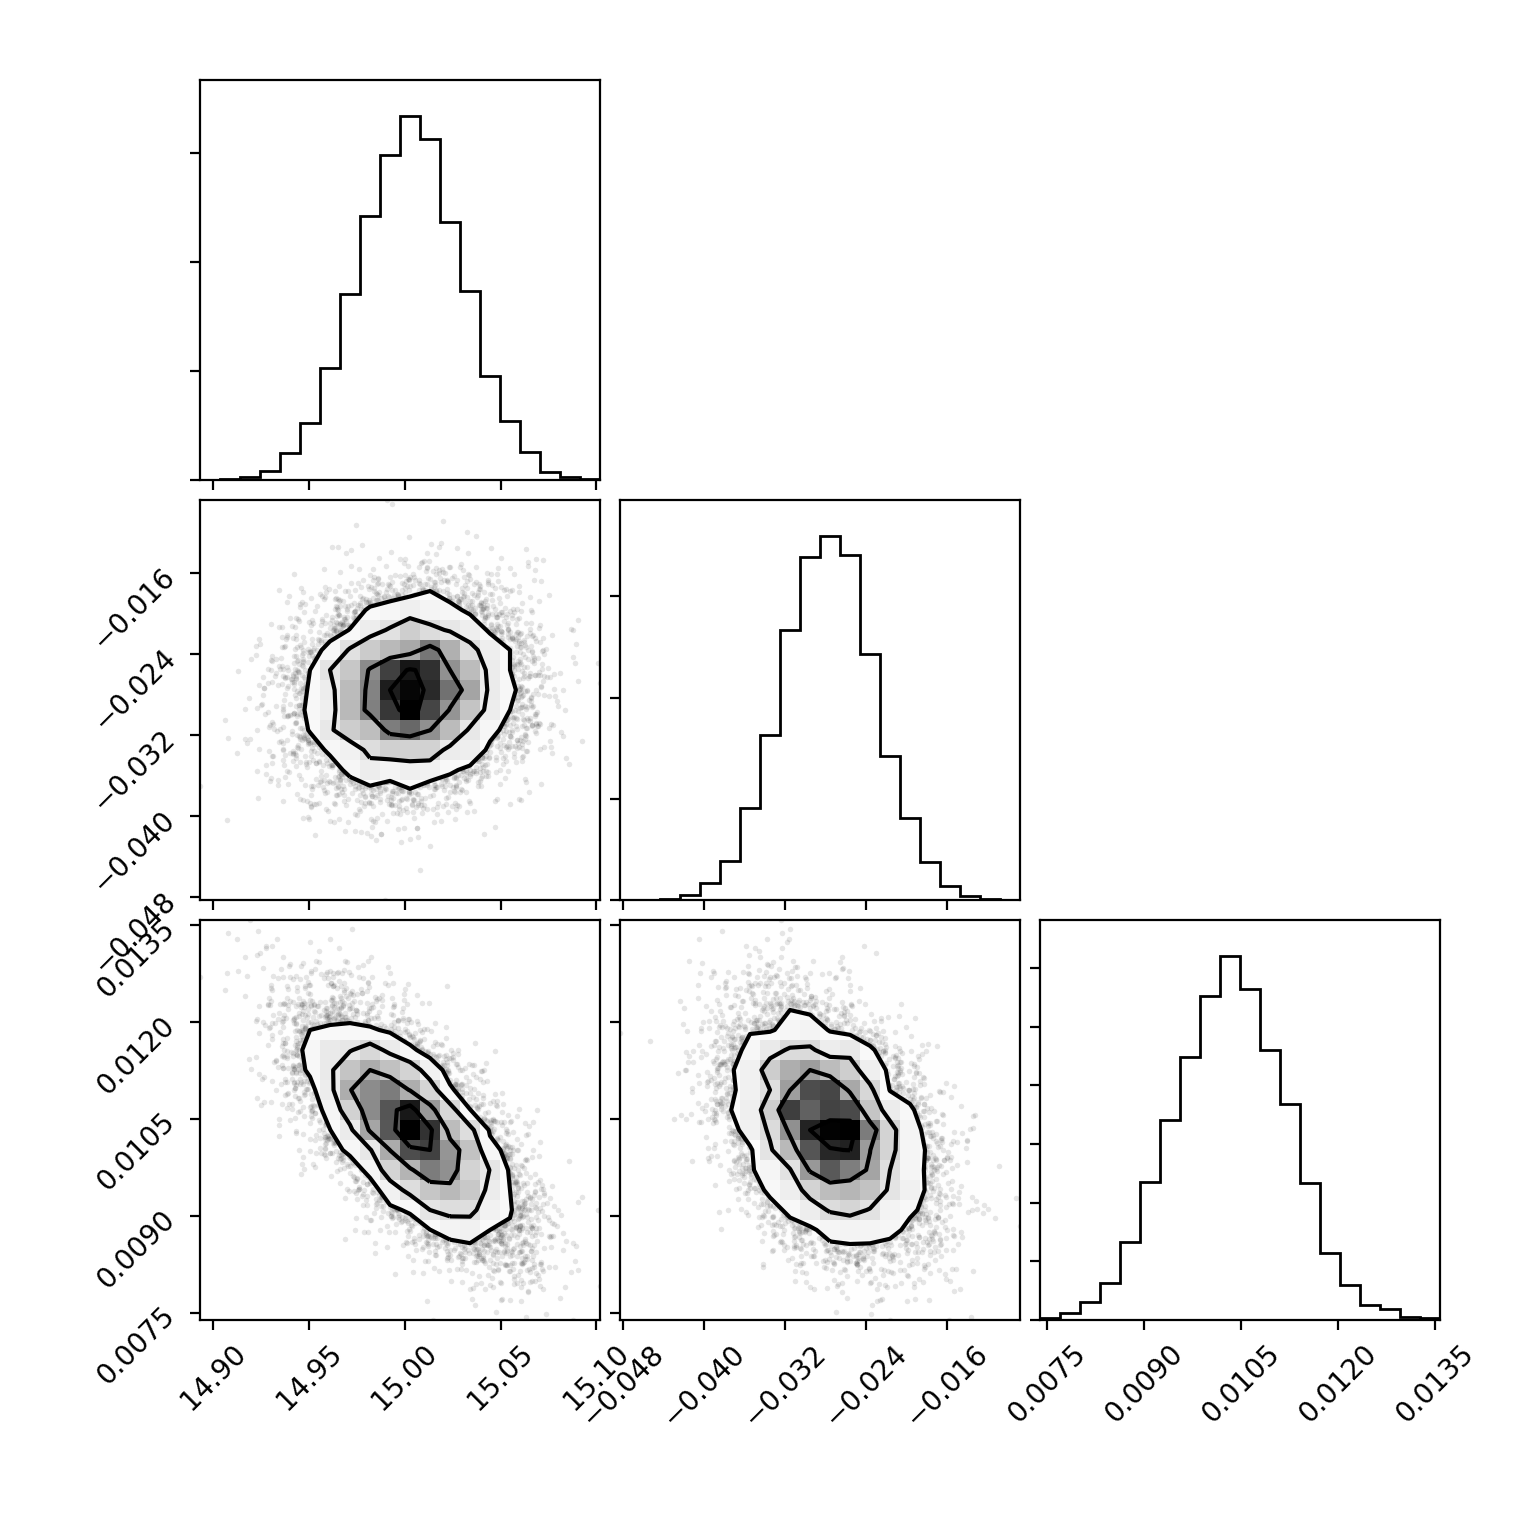

In [73]:
samples = sampler.get_chain(flat=True,
                            discard=10*np.ceil(np.max(tau)).astype(int),
                            thin=np.ceil(np.max(tau)).astype(int))
fig = corner.corner(samples)

<IPython.core.display.Javascript object>


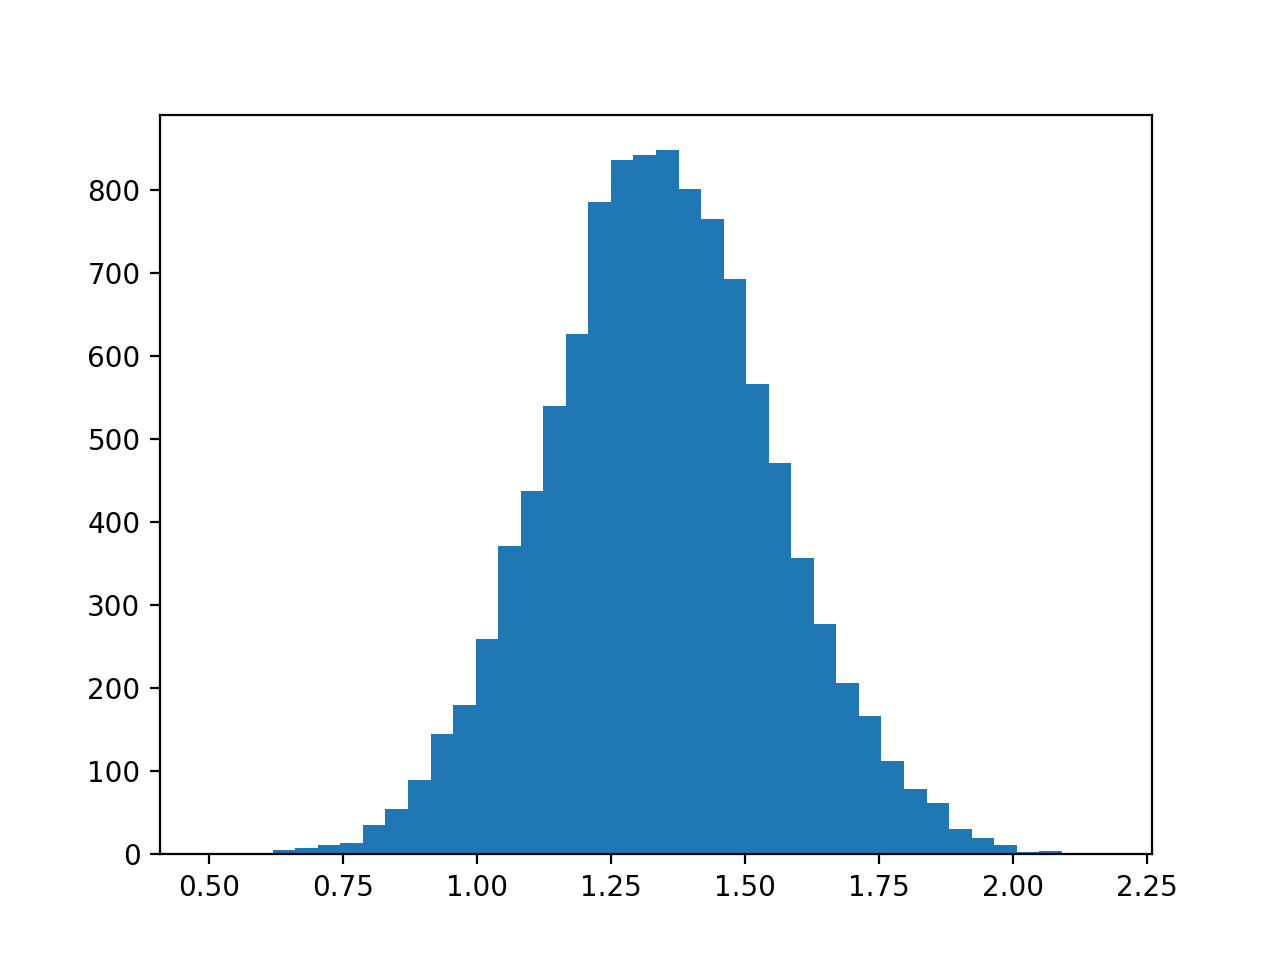

68% CR on t_peak is: [58863.12978909 58863.33935329 58863.55207163]


In [74]:
# derivative gives linear term
# peak = 


t_peak = -samples[:,1]/(2*samples[:,2])
plt.figure()
plt.hist(t_peak, bins=40)

print('68% CR on t_peak is: {}'.format(np.percentile(t_peak, (15.865,50,84.135)) + toffset))

<IPython.core.display.Javascript object>


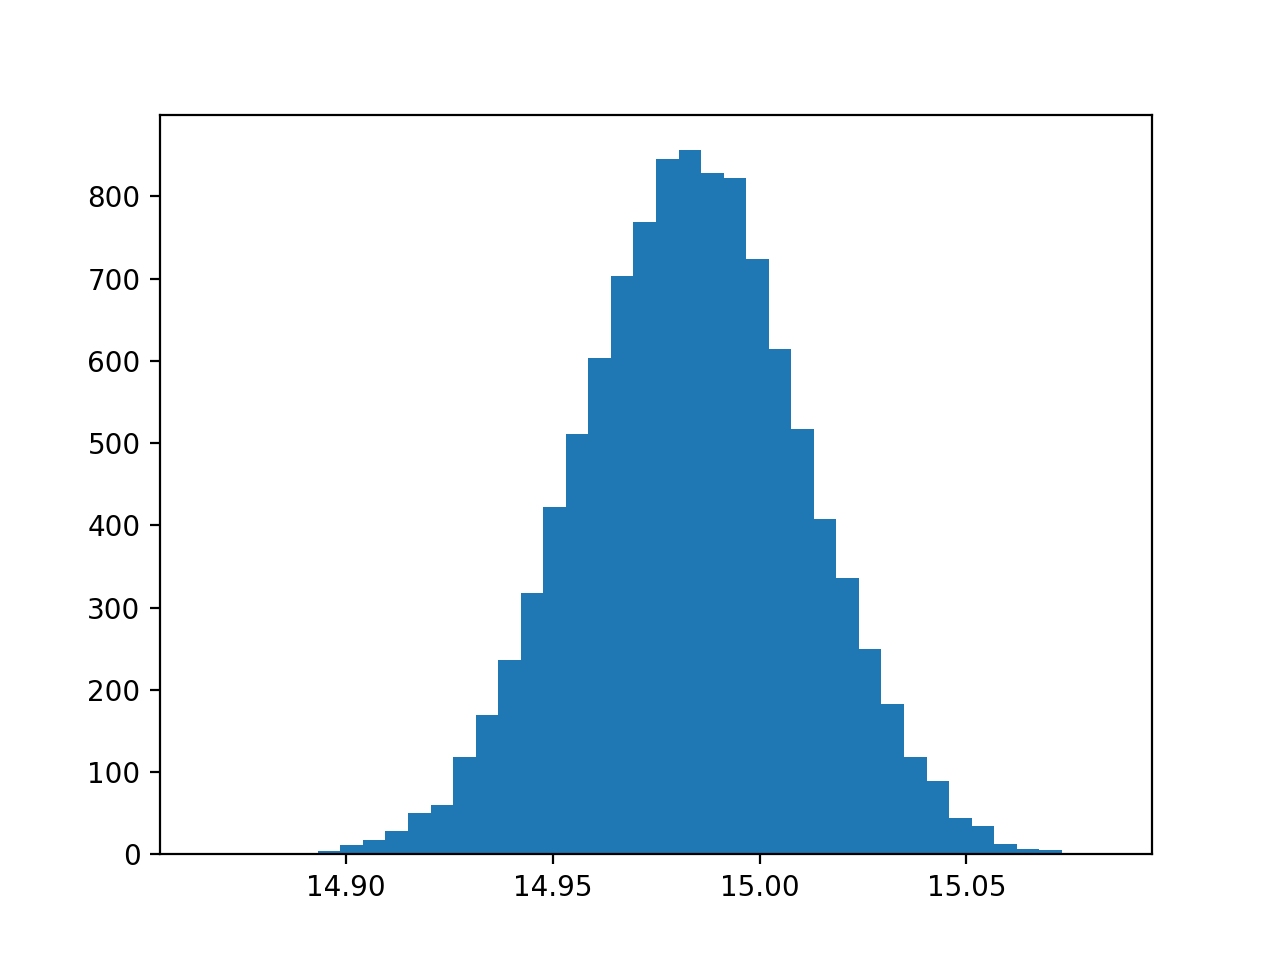

68% CR on t_peak is: [14.95614884 14.9835609  15.01068161]


In [77]:
b_max = samples[:,0] + samples[:,1]*t_peak + samples[:,2]*t_peak**2
plt.figure()
plt.hist(b_max, bins=40)

print('68% CR on t_peak is: {}'.format(np.percentile(b_max, (15.865,50,84.135))))